In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

## Maximum likelihood estimation of an increasing nonnegative signal

In [3]:
# create problem data 
N = 100; 

# create an increasing input signal
xtrue = np.zeros((N,1))
xtrue[1:40] = 0.1
xtrue[50] = 2
xtrue[70:80] = 0.15;
xtrue[80] = 1
xtrue = np.cumsum(xtrue)

# pass the increasing input through a moving-average filter 
# and add Gaussian noise
h = np.array([1, -0.85 ,0.7 ,-0.3])
k = h.shape[0]
yhat = np.convolve(h,xtrue)
y = yhat[:-3]\
    + np.array([-0.43,-1.7,0.13,0.29,-1.1,1.2,1.2,-0.038,0.33,0.17,-0.19,0.73,-0.59,2.2,-0.14,0.11,1.1,0.059,-0.096,-0.83,0.29,-1.3,0.71,1.6,-0.69,0.86,1.3,-1.6,-1.4,0.57,-0.4,0.69,0.82,0.71,1.3,0.67,1.2,-1.2,-0.02,-0.16,-1.6,0.26,-1.1,1.4,-0.81,0.53,0.22,-0.92,-2.2,-0.059,-1,0.61,0.51,1.7,0.59,-0.64,0.38,-1,-0.02,-0.048,4.3e-05,-0.32,1.1,-1.9,0.43,0.9,0.73,0.58,0.04,0.68,0.57,-0.26,-0.38,-0.3,-1.5,-0.23,0.12,0.31,1.4,-0.35,0.62,0.8,0.94,-0.99,0.21,0.24,-1,-0.74,1.1,-0.13,0.39,0.088,-0.64,-0.56,0.44,-0.95,0.78,0.57,-0.82,-0.27])

In [16]:
x = cp.Variable(N)
yh = cp.conv(h, x)[:-3,:]
obj = cp.Minimize(cp.sum_squares(y[:, np.newaxis] - yh))
constraints = [cp.diff(x) >= 0, x[0] >= 0]
prob = cp.Problem(obj, constraints)
prob.solve()
print("status :", prob.status)

status : optimal


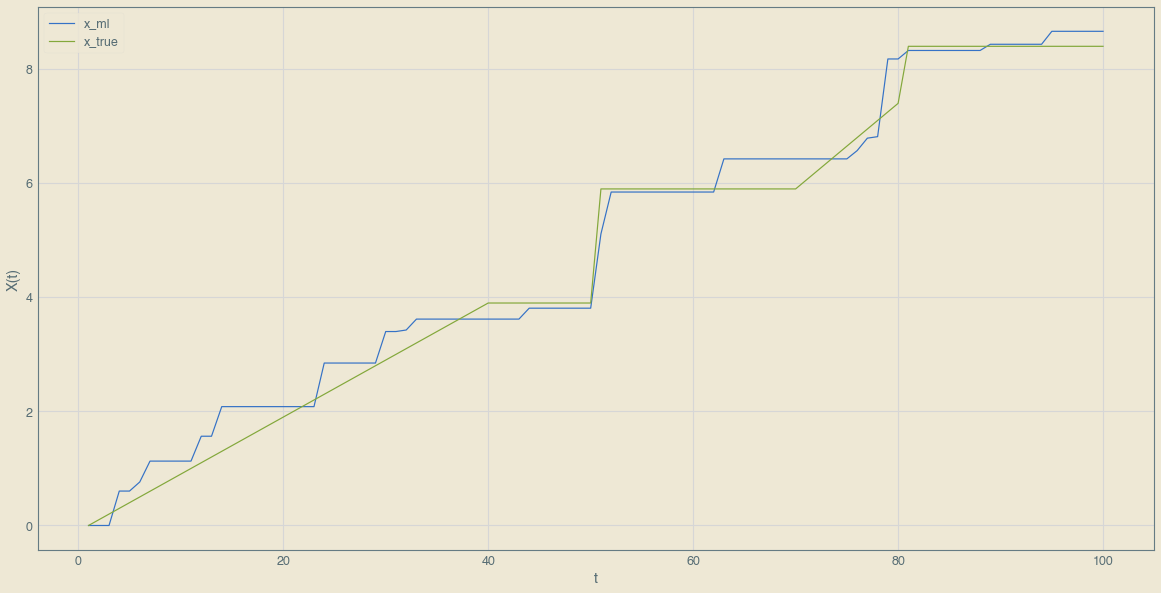

In [23]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(1, N + 1), x.value, label = "x_ml")
plt.plot(np.arange(1, N + 1), xtrue.flatten(), label = "x_true")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.legend()

In [25]:
prob_free = cp.Problem(obj)
prob_free.solve()
print("status :", prob_free.status)

status : optimal


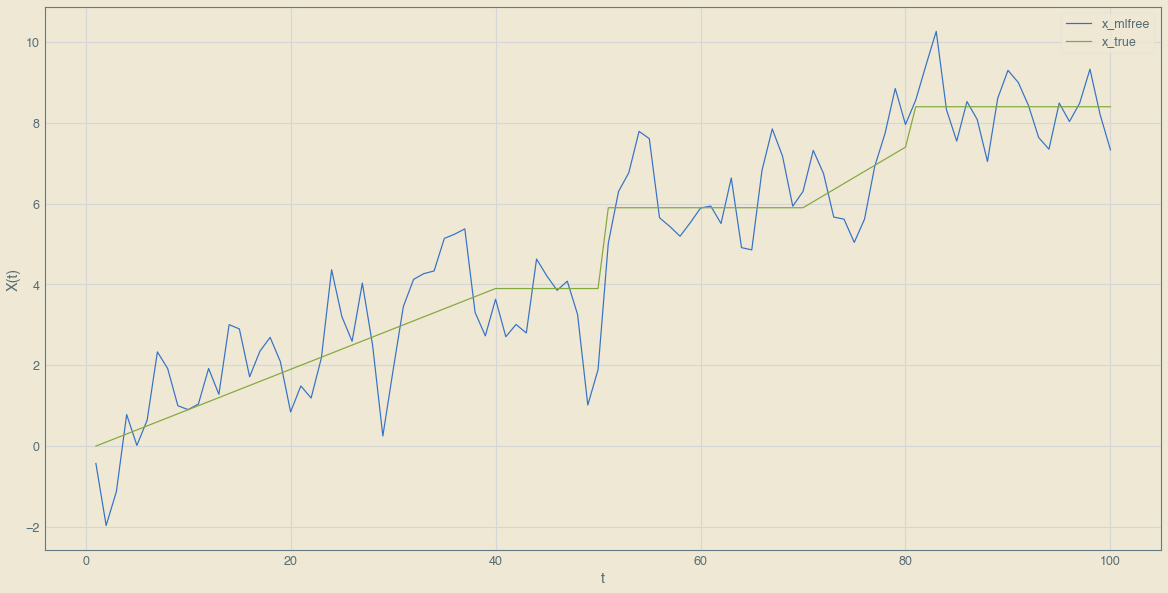

In [26]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(1, N + 1), x.value, label = "x_mlfree")
plt.plot(np.arange(1, N + 1), xtrue.flatten(), label = "x_true")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.legend()

##  worst-case probability of loss

In [27]:
mu1 = 8
mu2 = 20
sigma1 = 6
sigma2 = 17.5
rho = -0.25
N = 100
R = np.linspace(-30,69,100)
R1,R2 = np.meshgrid(R,R)
tot_return_mask = R1+R2 <= 0

In [30]:
p1 = np.exp(-(R - mu1)**2/(2*(sigma1**2)))
p1 /= np.sum(p1)
p2 = np.exp(-(R - mu2)**2/(2*(sigma2**2)))
p2 /= np.sum(p2)

In [33]:
P = cp.Variable((N, N), nonneg = True)
constraints = [cp.sum(P, 1) == p1,
               cp.sum(P, 0) == p2,
               (R - mu1)@P@(R - mu2) == rho*sigma1*sigma2]
obj = cp.Maximize(cp.sum(P[tot_return_mask]))
prob = cp.Problem(obj, constraints)
prob.solve()
print(prob.status)

optimal


In [34]:
print("P_loss_max :", prob.value)

P_loss_max : 0.1972308102481097


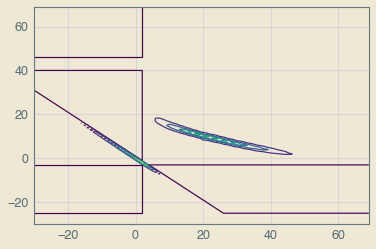

In [42]:
plt.contour(R1, R2, P.value)